In [2]:
import sys
import os
import numpy as np
import warnings
import geopandas as gpd
import folium

# path to folder to CityGeoTools
folder = "/var/essdata/IDU/other/Rest_/refactored/CityGeoTools"
sys.path.append(folder)

from metrics.data import CityInformationModel as BaseModel
from metrics.calculations import CityMetricsMethods as CityMetrics
from metrics.calculations import utils

warnings.simplefilter(action='ignore')

### Accessibility isochrones  

**Urban accessibility** is an urban area which a person is able to visit under existing space-time conditions. This concept is strongly related to peculiarities of pedestrian infrastructure and transport system of certain city. Depending on the type of travelling to the destination, three general types of accessibility are evaluated. These are pedestrian accessibility, accessibility by public transport and accessibility by private transport. 

So, first, to asses urban accessibility area, it's necessary to build intermodal mobility graph (how it is shown [here](https://github.com/iduprojects/CityGeoTools/blob/metrics-refactor/notebook_examples/get_mobility_graphs.ipynb)) and load it into City Information Model (following [this instructions](https://github.com/iduprojects/CityGeoTools/blob/master/notebook_examples/create_city_information_model.ipynb)). 


In [56]:
city_model = BaseModel.CityInformationModel(city_name="Saint-Petersburg", city_crs=32636, cwd="../")
city_model.update_layer("MobilityGraph", "./data/graph.graphml")

Validation of MobilityGraph layer...
MobilityGraph layer loaded successfully!


One of the representations of urban accessibility is an **accessibility isochron**. The isochron is a polygon covering the territory through which it is possible to move from the specified point within a **given time** or **travel distance**. To find a single source shortest path (SSSP problem) on the graph, Dijkstra's algorithm is used.

The principle of building isochrones is different for various travelling modes.
- Pedestrian or private transport accessibility isochrone *(as well as public transport accessibility isochrone assessed with travel distance)* is calculated by convex hull operation of all reachable nodes on the intermodal graph.  
  
- Public transport accessibility isochrone assessed with travel time is calculated by unary union operation of circles centered at each reachable node with radii equal to the distance traveled for the time left.

$$
NodeRadius = \frac{Time - \sum_{edge = 1}^{num}{EdgeWeigh}}{WalkSpeed}
$$ 
  

To build accessibility isochron, create an instanse of AccessibilityIsochrones class and call the method get_accessibility_isochrone with specified arguments:

**travel_type** - string (*public_transport*, *drive*, *walk*)  
**x_from** - integer (x coordinate of specified point in EPSG 4326)  
**y_from** - integer (y coordinate of specified point in EPSG 4326)  
**weight_value** - integer (limit value of accumulated edge weights)  
**weight_type** - string (weight of edges, *time_min* or *length_meter*)  
**routes** - boolean (show public transport routes, *default* - *False*)  

In [57]:
# project point from EPSG 4326 to EPSG 32636

point = [[59.941, 30.318]]
point = utils.request_points_project(point, set_crs=4326, to_crs=32636)[0]

if city_model.methods.if_method_available("accessibility_isochrones"):
    walk_accessibility_zone = CityMetrics.AccessibilityIsochrones(city_model).get_accessibility_isochrone(
        travel_type="walk",
        x_from=point[0], 
        y_from=point[1],
        weight_type = "length_meter",
        weight_value = 500)
    walk_isochrone = gpd.GeoDataFrame.from_features(walk_accessibility_zone["isochrone"]).set_crs(4326)

In [ ]:
map = folium.Map(location = [59.941, 30.318], zoom_start = 15, tiles='CartoDB positron')
folium.GeoJson(data=walk_isochrone, style_function=lambda x: {'fillColor': 'green'}).add_to(map)
folium.Marker([59.941, 30.318]).add_to(map)
map

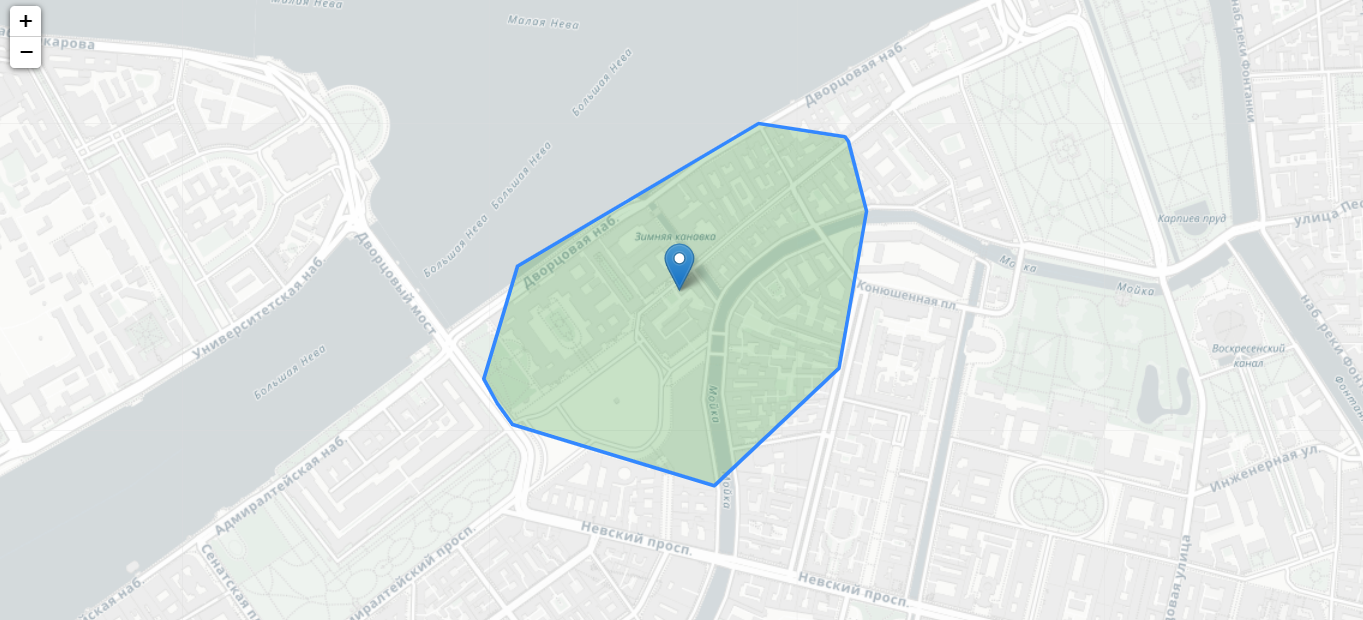

In [63]:
from IPython.display import Image, display
display(Image(filename='../img/accessibility_isochrones_walk.png', embed=True))

In [59]:
# project point from EPSG 4326 to EPSG 32636

point = [[59.841, 30.318]]
point = utils.request_points_project(point, set_crs=4326, to_crs=32636)[0]

if city_model.methods.if_method_available("accessibility_isochrones"):
    drive_accessibility_zone = CityMetrics.AccessibilityIsochrones(city_model).get_accessibility_isochrone(
        travel_type="drive",
        x_from=point[0], 
        y_from=point[1],
        weight_type = "time_min",
        weight_value = 10)
    drive_isochrone = gpd.GeoDataFrame.from_features(drive_accessibility_zone["isochrone"]).set_crs(4326)

In [ ]:
map = folium.Map(location = [59.841, 30.318], zoom_start = 13, tiles='CartoDB positron')
folium.GeoJson(data=drive_isochrone, style_function=lambda x: {'fillColor': 'orange'}).add_to(map)
folium.Marker([59.841, 30.318]).add_to(map)
map

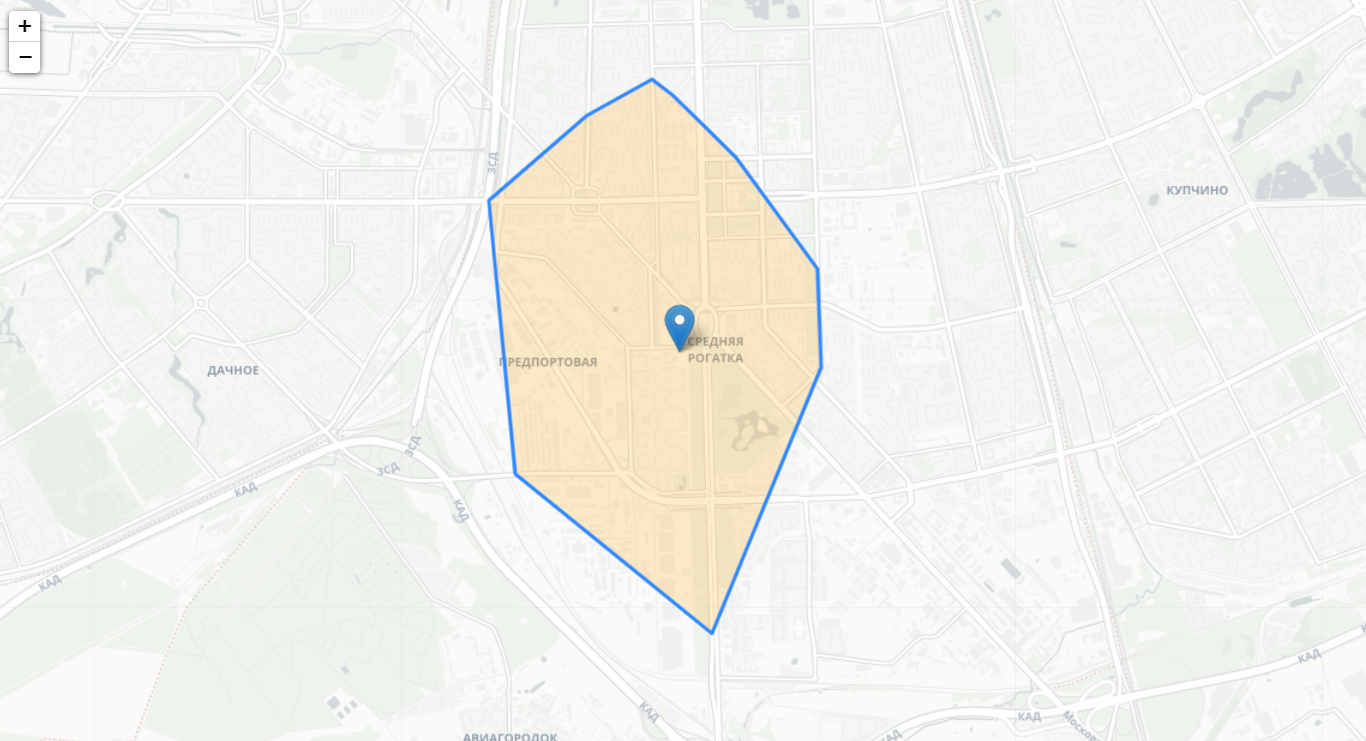

In [1]:
from IPython.display import Image, display
display(Image(filename='../img/accessibility_isochrones_drive.png', embed=True))

When calculating public transport accessibility isochrone, a walk network is considered and used to build an intermodal route.  
   
We assume that people start from random point on the street, then they walk to the nearest appropriate stop, get on a bus / trolleybus / tram / subway car, travel to another stop, perhaps they change a mode (for instance, after subway they decide to get on a bus), and after that they walk to the destination point.

In [61]:
# project point from EPSG 4326 to EPSG 32636

point = [[59.841, 30.318]]
point = utils.request_points_project(point, set_crs=4326, to_crs=32636)[0]

if city_model.methods.if_method_available("accessibility_isochrones"):
    pt_accessibility_zone = CityMetrics.AccessibilityIsochrones(city_model).get_accessibility_isochrone(
        travel_type="public_transport",
        x_from=point[0], 
        y_from=point[1],
        weight_type = "time_min",
        weight_value = 20,
        routes=True)
    pt_isochrone = gpd.GeoDataFrame.from_features(pt_accessibility_zone["isochrone"]).set_crs(4326)
    pt_stops = gpd.GeoDataFrame.from_features(pt_accessibility_zone["stops"]).set_crs(4326)
    pt_routes = gpd.GeoDataFrame.from_features(pt_accessibility_zone["routes"]).set_crs(4326)

In [ ]:
map = folium.Map(location = [59.841, 30.318], zoom_start = 13, tiles='CartoDB positron')
transport_color = {'tram': 'red', 'bus': 'orange', 'trolleybus': 'purple', 'subway':'green'}
style_function = lambda x: {'color': transport_color[x['properties']['type']], 'weight': 1}

folium.GeoJson(data=pt_isochrone, style_function=lambda x: {'fillColor': 'pink'}).add_to(map)
folium.GeoJson(data=pt_routes, style_function=style_function).add_to(map)
folium.GeoJson(data=pt_stops, marker=folium.CircleMarker(fill_color="blue", fill_opacity=1, radius=1)).add_to(map)
folium.Marker([59.841, 30.318]).add_to(map)
map

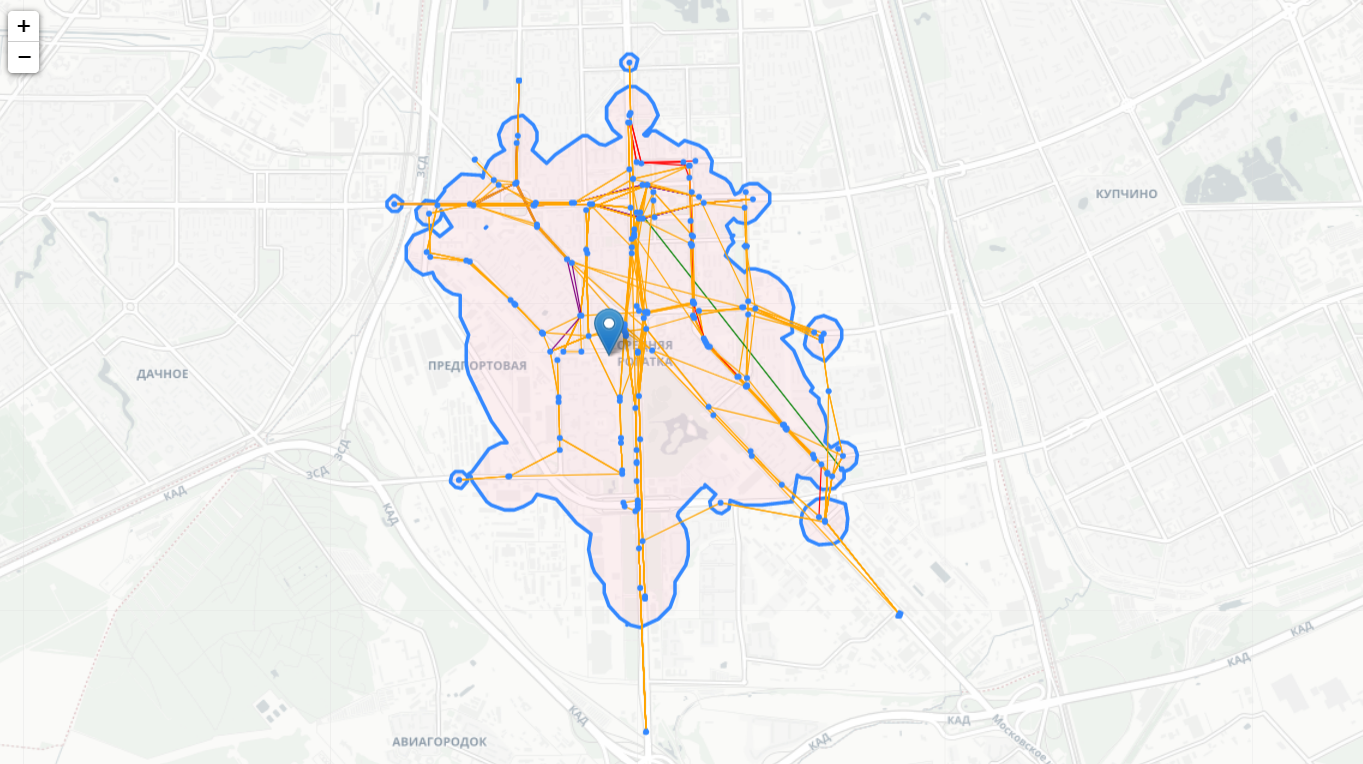

In [2]:
from IPython.display import Image, display
display(Image(filename='../img/accessibility_isochrones_pt.png', embed=True))